## Improved plot from HW8 based on the feedback

## Uber trip data on 20150115

In [4]:
import pandas as pd
import os
import shapely
from shapely import geometry
import geopandas as gpd
from geopandas import GeoDataFrame
from fiona.crs import from_epsg
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.mlab import bivariate_normal
from matplotlib import pyplot as plt
%matplotlib inline
import urllib.request
import glob
import choroplethNYC as cp

##### data from Uber's Kepler.gl site: https://kepler.gl/#/demo/nyctrips
click on "share" on the top left of the page and then choose "export data". I uploaded the data to my github so that you can download it. 

In [2]:
# download the csv I manually uploaded on Github
!wget https://raw.githubusercontent.com/effyfan/PUI2018_yf1150/master/Labs/kepler-gl_new_dataset.csv
# move it to PUIdata folder
!mv kepler-gl_new_dataset.csv $PUIDATA

--2018-11-07 19:36:17--  https://raw.githubusercontent.com/effyfan/PUI2018_yf1150/master/Labs/kepler-gl_new_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.200.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.200.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12087115 (12M) [text/plain]
Saving to: ‘kepler-gl_new_dataset.csv’

kepler-gl_new_datas 100%[===================>]  11.53M  --.-KB/s    in 0.1s    

2018-11-07 19:36:18 (78.5 MB/s) - ‘kepler-gl_new_dataset.csv’ saved [12087115/12087115]



In [3]:
uber = pd.read_csv("%s/kepler-gl_new_dataset.csv"%os.getenv("PUIDATA"))
uber.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tip_amount,total_amount
0,2,2015-01-15 19:05:39 +00:00,2015-01-15 19:23:42 +00:00,1,1.59,-73.993896,40.750111,-73.974785,40.750618,12.0,3.25,17.05
1,2,2015-01-15 19:05:39 +00:00,2015-01-15 19:32:00 +00:00,1,2.38,-73.976425,40.739811,-73.983978,40.757889,16.5,4.38,22.68
2,2,2015-01-15 19:05:40 +00:00,2015-01-15 19:21:00 +00:00,5,2.83,-73.968704,40.754246,-73.955124,40.786858,12.5,0.00,14.30
3,2,2015-01-15 19:05:40 +00:00,2015-01-15 19:28:18 +00:00,5,8.33,-73.863060,40.769581,-73.952713,40.785782,26.0,8.08,41.21
4,2,2015-01-15 19:05:41 +00:00,2015-01-15 19:20:36 +00:00,1,2.37,-73.945541,40.779423,-73.980850,40.786083,11.5,0.00,13.30


In [5]:
# create a new column that combines lat and lon
uber['pickup_lonlat'] = list(zip(uber.pickup_longitude, uber.pickup_latitude))
uber.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tip_amount,total_amount,pickup_lonlat
0,2,2015-01-15 19:05:39 +00:00,2015-01-15 19:23:42 +00:00,1,1.59,-73.993896,40.750111,-73.974785,40.750618,12.0,3.25,17.05,"(-73.99389648, 40.75011063)"
1,2,2015-01-15 19:05:39 +00:00,2015-01-15 19:32:00 +00:00,1,2.38,-73.976425,40.739811,-73.983978,40.757889,16.5,4.38,22.68,"(-73.97642517, 40.73981094)"
2,2,2015-01-15 19:05:40 +00:00,2015-01-15 19:21:00 +00:00,5,2.83,-73.968704,40.754246,-73.955124,40.786858,12.5,0.00,14.30,"(-73.96870422, 40.75424576)"
3,2,2015-01-15 19:05:40 +00:00,2015-01-15 19:28:18 +00:00,5,8.33,-73.863060,40.769581,-73.952713,40.785782,26.0,8.08,41.21,"(-73.86306, 40.76958084)"
4,2,2015-01-15 19:05:41 +00:00,2015-01-15 19:20:36 +00:00,1,2.37,-73.945541,40.779423,-73.980850,40.786083,11.5,0.00,13.30,"(-73.94554138, 40.77942276)"


In [6]:
# Create Point Geometry from lonlat column
uber['geometry'] = uber[['pickup_lonlat']].applymap(lambda x:shapely.geometry.Point(x))
uber.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tip_amount,total_amount,pickup_lonlat,geometry
0,2,2015-01-15 19:05:39 +00:00,2015-01-15 19:23:42 +00:00,1,1.59,-73.993896,40.750111,-73.974785,40.750618,12.0,3.25,17.05,"(-73.99389648, 40.75011063)",POINT (-73.99389648 40.75011063)
1,2,2015-01-15 19:05:39 +00:00,2015-01-15 19:32:00 +00:00,1,2.38,-73.976425,40.739811,-73.983978,40.757889,16.5,4.38,22.68,"(-73.97642517, 40.73981094)",POINT (-73.97642517 40.73981094)
2,2,2015-01-15 19:05:40 +00:00,2015-01-15 19:21:00 +00:00,5,2.83,-73.968704,40.754246,-73.955124,40.786858,12.5,0.00,14.30,"(-73.96870422, 40.75424576)",POINT (-73.96870422000001 40.75424576)
3,2,2015-01-15 19:05:40 +00:00,2015-01-15 19:28:18 +00:00,5,8.33,-73.863060,40.769581,-73.952713,40.785782,26.0,8.08,41.21,"(-73.86306, 40.76958084)",POINT (-73.86306 40.76958084)
4,2,2015-01-15 19:05:41 +00:00,2015-01-15 19:20:36 +00:00,1,2.37,-73.945541,40.779423,-73.980850,40.786083,11.5,0.00,13.30,"(-73.94554138, 40.77942276)",POINT (-73.94554137999999 40.77942276)


In [7]:
type(uber)

pandas.core.frame.DataFrame

In [8]:
# convert the padas dataframe to geopandas datagrame
geouber = GeoDataFrame(uber)
geouber.crs = from_epsg(4326)
type(geouber)

geopandas.geodataframe.GeoDataFrame

In [9]:
geouber.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tip_amount,total_amount,pickup_lonlat,geometry
0,2,2015-01-15 19:05:39 +00:00,2015-01-15 19:23:42 +00:00,1,1.59,-73.993896,40.750111,-73.974785,40.750618,12.0,3.25,17.05,"(-73.99389648, 40.75011063)",POINT (-73.99389648 40.75011063)
1,2,2015-01-15 19:05:39 +00:00,2015-01-15 19:32:00 +00:00,1,2.38,-73.976425,40.739811,-73.983978,40.757889,16.5,4.38,22.68,"(-73.97642517, 40.73981094)",POINT (-73.97642517 40.73981094)
2,2,2015-01-15 19:05:40 +00:00,2015-01-15 19:21:00 +00:00,5,2.83,-73.968704,40.754246,-73.955124,40.786858,12.5,0.00,14.30,"(-73.96870422, 40.75424576)",POINT (-73.96870422000001 40.75424576)
3,2,2015-01-15 19:05:40 +00:00,2015-01-15 19:28:18 +00:00,5,8.33,-73.863060,40.769581,-73.952713,40.785782,26.0,8.08,41.21,"(-73.86306, 40.76958084)",POINT (-73.86306 40.76958084)
4,2,2015-01-15 19:05:41 +00:00,2015-01-15 19:20:36 +00:00,1,2.37,-73.945541,40.779423,-73.980850,40.786083,11.5,0.00,13.30,"(-73.94554138, 40.77942276)",POINT (-73.94554137999999 40.77942276)


In [9]:
# geouber.plot(column='tip_amount', cmap='Reds', markersize=3)

In [10]:
# geouber_2263 = geouber.to_crs(epsg=2263)
# geouber_2263.plot(column='tip_amount', cmap='Reds', markersize=3)

In [13]:
# get nyc borough boundries shape file
url = "https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile"
urllib.request.urlretrieve(url, "file.gz")
# unzip and move data to the PUIdata folder
!unzip file.gz -d $PUIDATA/UBER

Archive:  file.gz
  inflating: /nfshome/yf1150/PUIdata/UBER/geo_export_06d4ba09-9349-4e3f-9c08-36f34e267832.dbf  
  inflating: /nfshome/yf1150/PUIdata/UBER/geo_export_06d4ba09-9349-4e3f-9c08-36f34e267832.shp  
  inflating: /nfshome/yf1150/PUIdata/UBER/geo_export_06d4ba09-9349-4e3f-9c08-36f34e267832.shx  
  inflating: /nfshome/yf1150/PUIdata/UBER/geo_export_06d4ba09-9349-4e3f-9c08-36f34e267832.prj  


In [10]:
# read the shapefile
nycshp=gpd.GeoDataFrame.from_file(glob.glob(os.path.join(os.getenv("PUIDATA"), 'UBER/','*.shp'))[0])

In [11]:
nycshp.head()

,boro_code,boro_name,shape_area,shape_leng,geometry
0,1.0,Manhattan,6.366006e+08,361649.881587,(POLYGON ((-74.01092841268031 40.6844914725429...
1,2.0,Bronx,1.186615e+09,463464.521828,(POLYGON ((-73.89680883223774 40.7958084451597...
2,5.0,Staten Island,1.623921e+09,330432.867999,(POLYGON ((-74.05050806403247 40.5664220341608...
3,3.0,Brooklyn,1.937567e+09,739945.437431,(POLYGON ((-73.86706149472118 40.5820879767934...
4,4.0,Queens,3.044772e+09,895228.960360,(POLYGON ((-73.83668274106707 40.5949466970158...


Text(0.5,1,'NYC Borough Boundries')

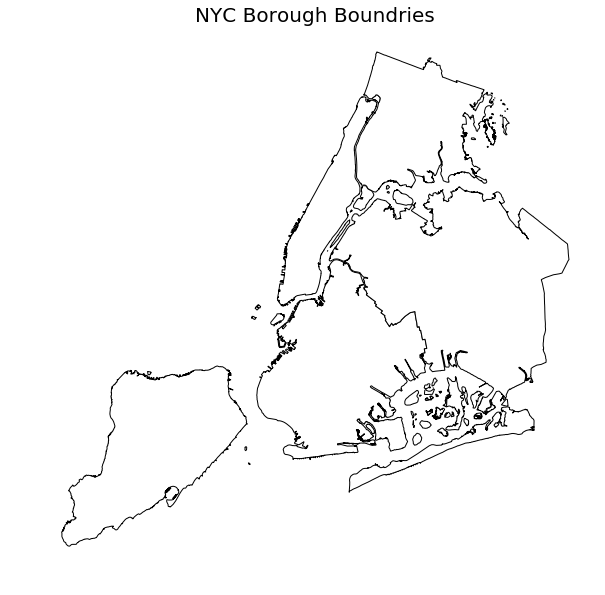

In [12]:
cp.choroplethNYC(nycshp, column=None, color="white", edgecolor="black", lw=1);
plt.title("NYC Borough Boundries", fontsize=20)

Text(0.5,1,'Uber Trips on 20150115')

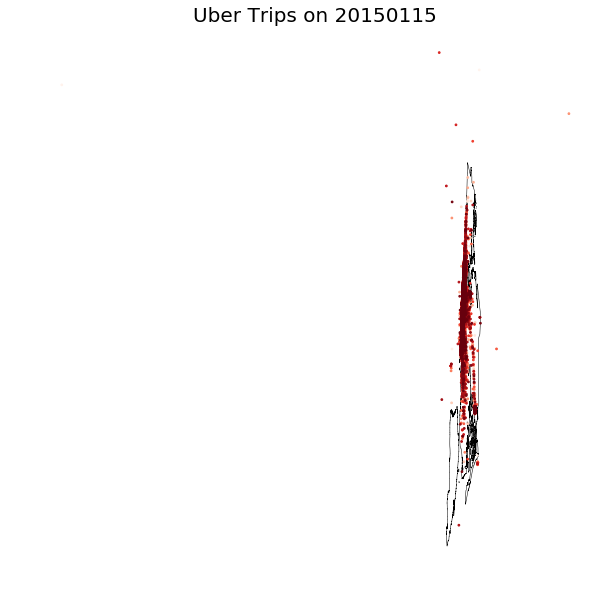

In [13]:
# stack two map together
fig,ax = cp.choroplethNYC(nycshp, column=None, color="white", edgecolor="black", lw=0.5)
geouber.plot(column=None, cmap='Reds', ax = ax, markersize=3)
plt.title("Uber Trips on 20150115", fontsize=20)

### because the dataset is too large, i decided to use only manhattan data

Text(0.5,1,'Manhattan Borough Boundries')

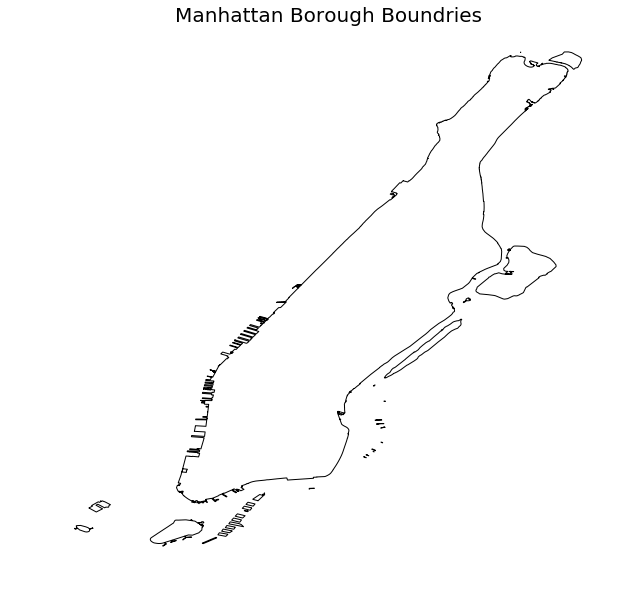

In [14]:
# get the manhattan boundry
cp.choroplethNYC(nycshp.loc[[0], 'geometry'], column=None, color="white", edgecolor="black", lw=1);
plt.title("Manhattan Borough Boundries", fontsize=20)

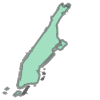

In [15]:
nycshp.ix[0].geometry

##### Be careful, this following cell may take a while. On average 1-2 mins

In [ ]:
# warning: this cell may take a while
# filter the dataframe to get only manhattan data
man_boundary = nycshp.ix[0].geometry
uber_man = geouber[geouber.geometry.within(man_boundary)]

In [18]:
uber_man.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tip_amount,total_amount,pickup_lonlat,geometry
0,2,2015-01-15 19:05:39 +00:00,2015-01-15 19:23:42 +00:00,1,1.59,-73.993896,40.750111,-73.974785,40.750618,12.0,3.25,17.05,"(-73.99389648, 40.75011063)",POINT (-73.99389648 40.75011063)
1,2,2015-01-15 19:05:39 +00:00,2015-01-15 19:32:00 +00:00,1,2.38,-73.976425,40.739811,-73.983978,40.757889,16.5,4.38,22.68,"(-73.97642517, 40.73981094)",POINT (-73.97642517 40.73981094)
2,2,2015-01-15 19:05:40 +00:00,2015-01-15 19:21:00 +00:00,5,2.83,-73.968704,40.754246,-73.955124,40.786858,12.5,0.00,14.30,"(-73.96870422, 40.75424576)",POINT (-73.96870422000001 40.75424576)
4,2,2015-01-15 19:05:41 +00:00,2015-01-15 19:20:36 +00:00,1,2.37,-73.945541,40.779423,-73.980850,40.786083,11.5,0.00,13.30,"(-73.94554138, 40.77942276)",POINT (-73.94554137999999 40.77942276)
6,2,2015-01-15 19:05:41 +00:00,2015-01-15 19:31:00 +00:00,1,3.60,-73.976601,40.751896,-73.998924,40.714596,17.5,0.00,19.30,"(-73.97660065, 40.7518959)",POINT (-73.97660064999999 40.75189589999999)


In [25]:
# br_boundary = nycshp.ix[1].geometry
# uber_br = geouber[geouber.geometry.within(man_boundary)]

Text(0.5,1,'Uber trips started at Manhanttan on Jan 15th, 2015')

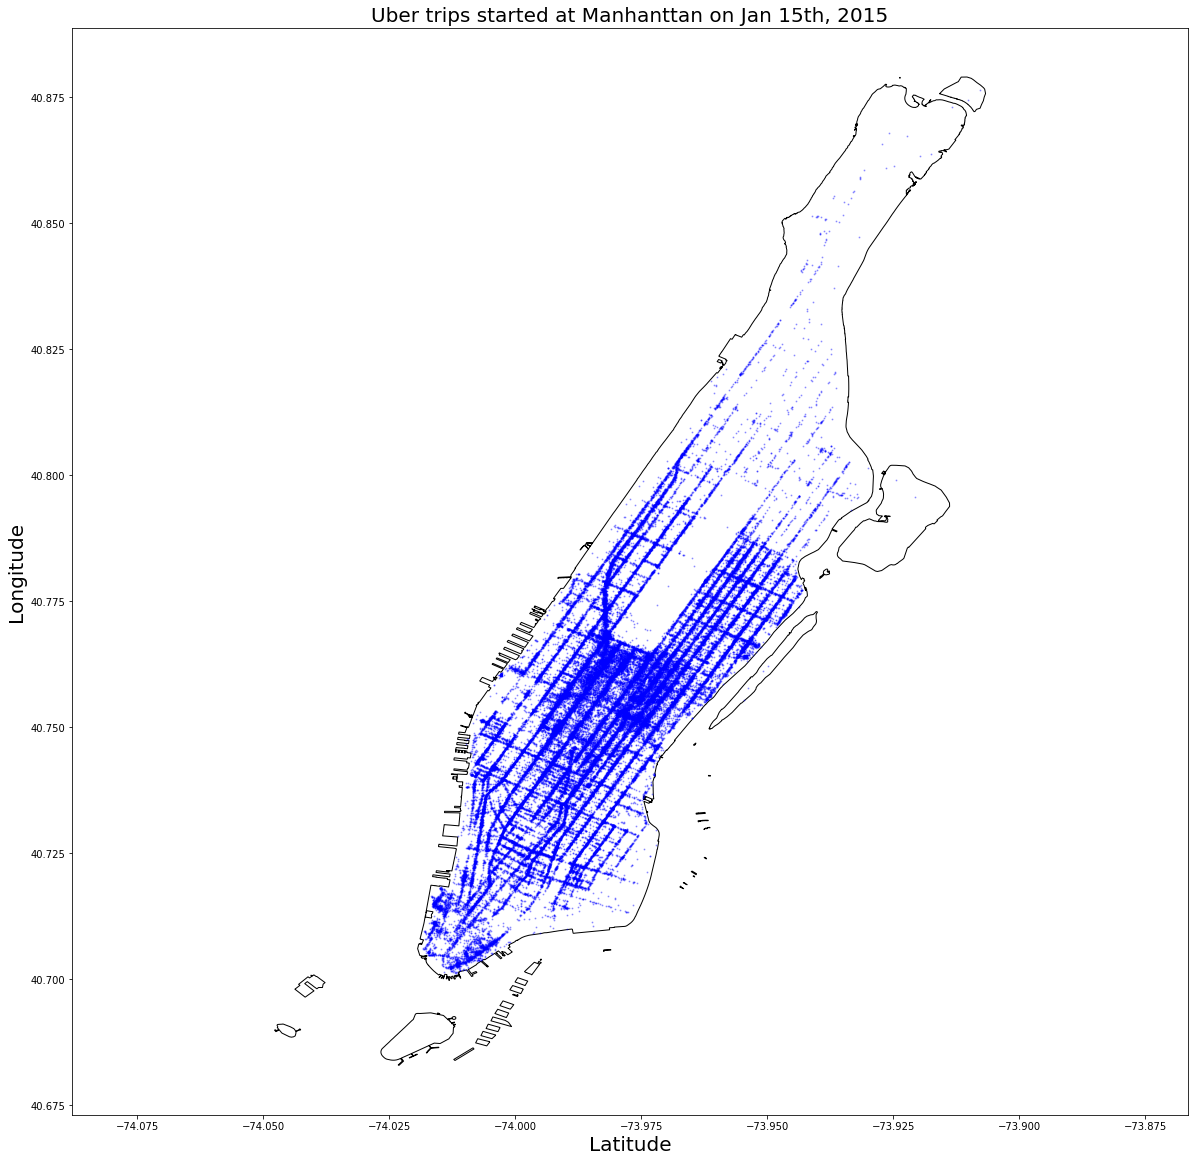

In [57]:
ax = nycshp.loc[[0], 'geometry'].plot(edgecolor = "black", color = 'white', figsize=(20, 20))
ax.axes.set_aspect('equal','datalim')
uber_man.plot(column=None, color='blue', alpha = 0.3, ax = ax, markersize=1, legend=True)
plt.xlabel('Latitude', fontsize=20)
plt.ylabel('Longitude', fontsize=20)
plt.title('Uber trips started at Manhanttan on Jan 15th, 2015', fontsize=20)

## Figure 1: Map of Uber trips' start location that was started at Manhanttan on Jan 15th, 2015

## Number of Passanger

In [19]:
cmap = plt.cm.plasma
cmap_reversed = plt.cm.get_cmap('plasma_r')

Text(0.5,1,'Uber trips start location and the number of passengers each trip in Manhanttan on Jan 15th, 2015.')

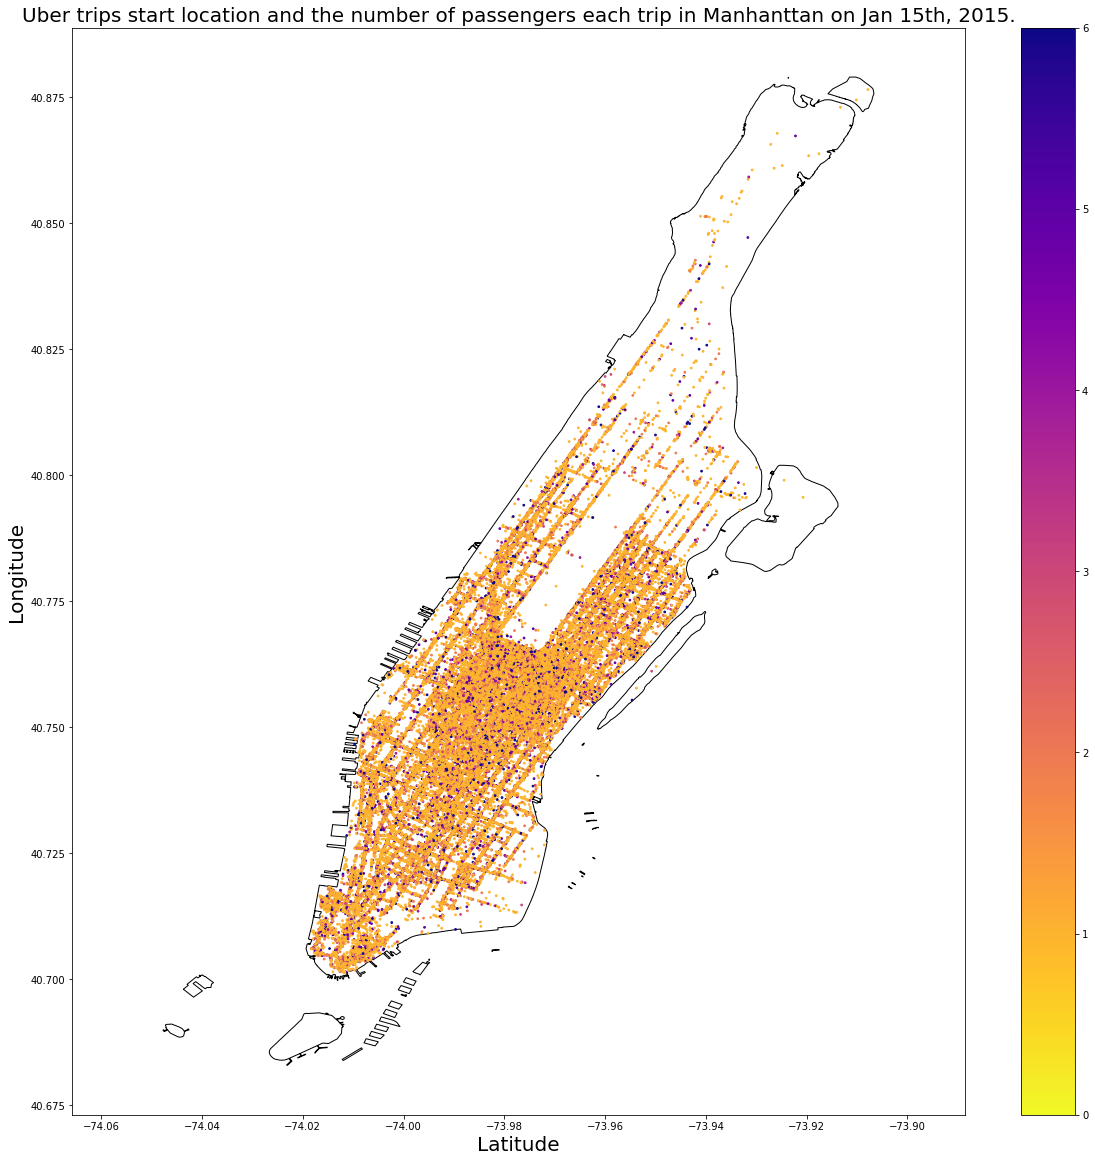

In [51]:
# stack two map together
ax = nycshp.loc[[0], 'geometry'].plot(edgecolor = "black", color = 'white', figsize=(20, 20))
#set the axis differently
ax.axes.set_aspect('equal','datalim')
uber_man.plot(column='passenger_count', cmap=cmap_reversed, ax = ax, markersize=3, legend=True)
plt.xlabel('Latitude', fontsize=20)
plt.ylabel('Longitude', fontsize=20)
plt.title('Uber trips start location and the number of passengers each trip in Manhanttan on Jan 15th, 2015.', fontsize=20)

## Figure 2: Map of color-coded Uber trips' start location reflecting the number of passengers each trip in Manhanttan on Jan 15th, 2015. (less passenger is more yellow and more passenger is more purple). This map shows most trips have 2 passengers and small number of trips has more then 3 passengers. The distribution of number of passengers is spreaded out. 

### I think it is necessary to perform a spatial join with PUMA zones for this data to see the spatial distribution of tip persentage. 

In [ ]:
## download puma data
url = "https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile"
urllib.request.urlretrieve(url, "file.gz")
# unzip and move data to the PUIdata folder
!unzip file.gz -d $PUIDATA/PUMA

In [21]:
# read the shapefile
pumashp=gpd.GeoDataFrame.from_file(glob.glob(os.path.join(os.getenv("PUIDATA"), 'PUMA/','*.shp'))[0])

In [22]:
pumashp.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [23]:
pumashp.shape

(55, 4)

In [24]:
# get only manhattan puma
# puma_man = pumashp[pumashp.geometry.within(man_boundary)]

In [25]:
# puma_man_2263 = puma_man.to_crs(epsg=2263)
# puma_man_2263.crs

In [26]:
pumashp_2263 = pumashp.to_crs(epsg=2263)
pumashp_2263.crs

{'init': 'epsg:2263', 'no_defs': True}

In [27]:
pumashp_2263.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,..."
1,3702,1.889860e+08,106050.002302,"POLYGON ((1027331.841796877 256069.2766112776,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((1042822.450195312 243439.8142089319...
3,3704,1.062129e+08,47970.901277,"POLYGON ((1026308.769592285 256767.6972045382,..."
4,4015,8.105438e+07,50007.415493,"POLYGON ((997086.4570312516 171933.9880370507,..."


In [28]:
# puma_man_2263.head()

In [29]:
uber_man_2263 = uber_man.to_crs(epsg=2263)
uber_man_2263.crs

{'init': 'epsg:2263', 'no_defs': True}

In [30]:
uber_man_2263 = uber_man_2263.reset_index()
uber_man_2263.head()

,index,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tip_amount,total_amount,pickup_lonlat,geometry
0,0,2,2015-01-15 19:05:39 +00:00,2015-01-15 19:23:42 +00:00,1,1.59,-73.993896,40.750111,-73.974785,40.750618,12.0,3.25,17.05,"(-73.99389648, 40.75011063)",POINT (985941.1169927303 212562.2516220818)
1,1,2,2015-01-15 19:05:39 +00:00,2015-01-15 19:32:00 +00:00,1,2.38,-73.976425,40.739811,-73.983978,40.757889,16.5,4.38,22.68,"(-73.97642517, 40.73981094)",POINT (990782.9447805608 208810.5656303262)
2,2,2,2015-01-15 19:05:40 +00:00,2015-01-15 19:21:00 +00:00,5,2.83,-73.968704,40.754246,-73.955124,40.786858,12.5,0.00,14.30,"(-73.96870422, 40.75424576)",POINT (992920.6587459923 214070.3031278186)
3,4,2,2015-01-15 19:05:41 +00:00,2015-01-15 19:20:36 +00:00,1,2.37,-73.945541,40.779423,-73.980850,40.786083,11.5,0.00,13.30,"(-73.94554138, 40.77942276)",POINT (999332.3408033819 223246.2573359719)
4,6,2,2015-01-15 19:05:41 +00:00,2015-01-15 19:31:00 +00:00,1,3.60,-73.976601,40.751896,-73.998924,40.714596,17.5,0.00,19.30,"(-73.97660065, 40.7518959)",POINT (990733.1404669296 213213.490074725)


In [31]:
uber_man_2263.columns

Index(['index', 'VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'fare_amount', 'tip_amount', 'total_amount', 'pickup_lonlat',
       'geometry'],
      dtype='object')

In [32]:
uber_man_2263.drop(['index', 'VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime','pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_lonlat'], axis = 1, inplace = True)

In [33]:
uber_man_2263.head()

,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,geometry
0,1,1.59,12.0,3.25,17.05,POINT (985941.1169927303 212562.2516220818)
1,1,2.38,16.5,4.38,22.68,POINT (990782.9447805608 208810.5656303262)
2,5,2.83,12.5,0.00,14.30,POINT (992920.6587459923 214070.3031278186)
3,1,2.37,11.5,0.00,13.30,POINT (999332.3408033819 223246.2573359719)
4,1,3.60,17.5,0.00,19.30,POINT (990733.1404669296 213213.490074725)


In [34]:
# sjoin puma shapefile and uber manhattan data with average passenger count in each puma
uber_joined = gpd.sjoin(uber_man_2263,pumashp_2263)[['puma', 'passenger_count']].groupby('puma')['passenger_count'].mean()
uber_joined.head()

puma
3801    1.670213
3802    1.662864
3803    1.800570
3804    1.575434
3805    1.638447
Name: passenger_count, dtype: float64

In [35]:
# uber_joined = gpd.sjoin(uber_man_2263,pumashp_2263).groupby(['Prop ID'])['condition'].mean()
# uber_joined.head()

In [36]:
uber_joined = uber_joined.reset_index()

In [37]:
uber_joined.head()

,puma,passenger_count
0,3801,1.670213
1,3802,1.662864
2,3803,1.800570
3,3804,1.575434
4,3805,1.638447


In [38]:
uber_joined.columns = ['puma', 'passenger_mean']
uber_joined.head()

,puma,passenger_mean
0,3801,1.670213
1,3802,1.662864
2,3803,1.800570
3,3804,1.575434
4,3805,1.638447


In [39]:
uber_puma = pumashp.merge(uber_joined, on='puma', how='outer')
uber_puma.head()

,puma,shape_area,shape_leng,geometry,passenger_mean
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,NaN
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",NaN
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,NaN
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",NaN
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,NaN


In [40]:
uber_puma.columns

Index(['puma', 'shape_area', 'shape_leng', 'geometry', 'passenger_mean'], dtype='object')

In [41]:
uber_puma['passenger_mean'] = uber_puma['passenger_mean'].fillna(0)
uber_puma.head()

,puma,shape_area,shape_leng,geometry,passenger_mean
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,0.0
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",0.0
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,0.0
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",0.0
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,0.0


In [42]:
uber_puma.shape

(55, 5)

## Major modification based on the feedbacks from HW8. 

In [46]:
# filter the puma to Manhattan only, puma between 3801-3810 are manhattan
pumaMan = ['3801', '3802', '3803', '3804', '3805', '3806', '3807', '3808', '3809', '3810']
uber_pumaMan = uber_puma[uber_puma.puma.isin(pumaMan)]

In [47]:
uber_pumaMan.shape

(10, 5)

Text(0.5,1,'Average number of passengers per trip in Manhattan on 20150115 in PUMA zones')

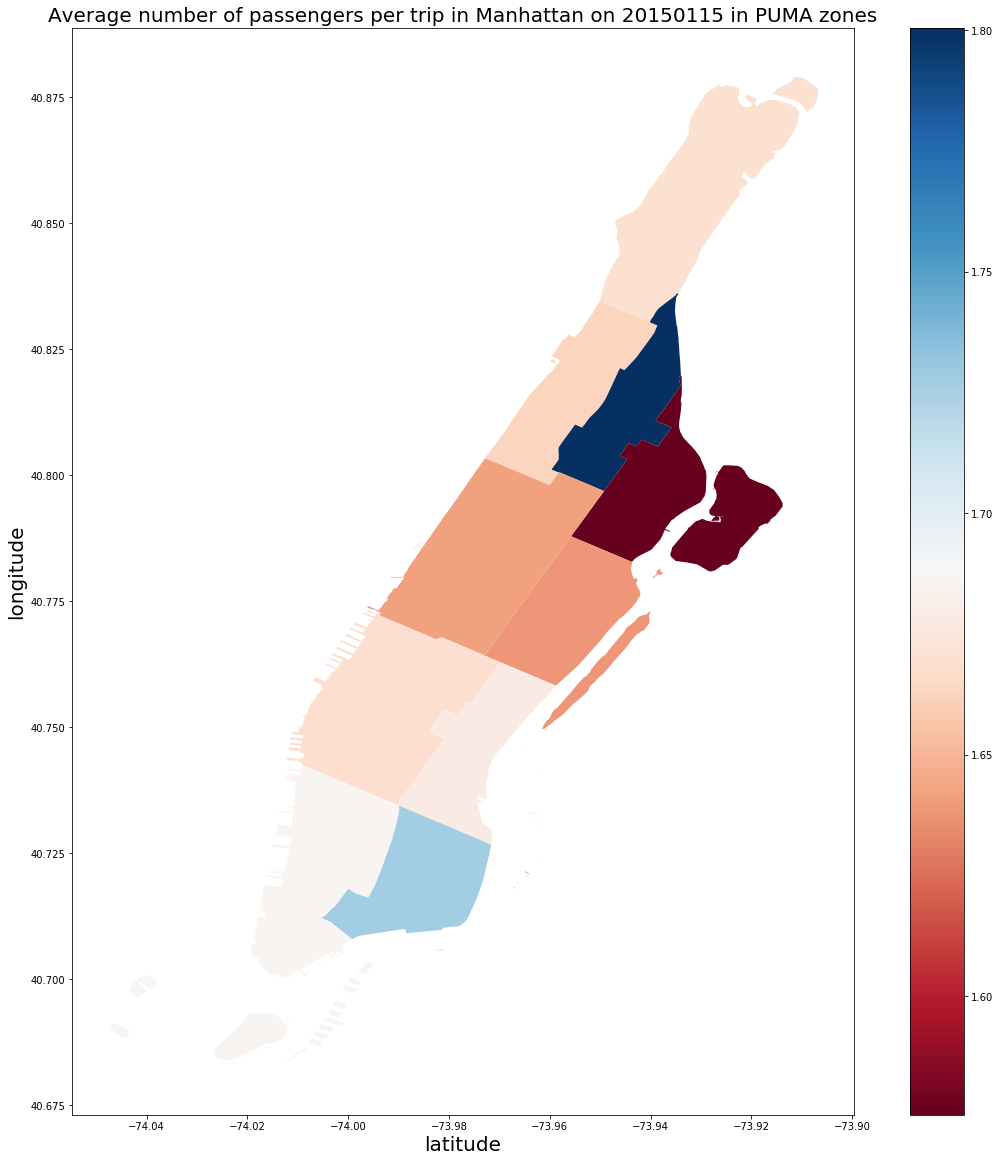

In [56]:
ax = uber_pumaMan.plot(column="passenger_mean", k=3, cmap="RdBu", legend=True, figsize=(20,20))
ax.set_xlabel("latitude", fontsize=20)
ax.set_ylabel("longitude", fontsize=20)
plt.title('Average number of passengers per trip in Manhattan on 20150115 in PUMA zones', fontsize=20)

## Figure 3: Average number of passengers per trip in Manhattan on 20150115 in PUMA zones. It shows the upper manhattan has the largest average number of passengers per trip, follow by lower east side. This map shows big spatial correlation for the south half of manhattan and little correlation for the north half of manhattan. 

## Tip Percentage

In [58]:
# calculate the tip percentage
uber_man['tip_percent'] = uber_man['tip_amount'] / uber_man['fare_amount']
uber_man.head()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tip_amount,total_amount,pickup_lonlat,geometry,tip_percent
0,2,2015-01-15 19:05:39 +00:00,2015-01-15 19:23:42 +00:00,1,1.59,-73.993896,40.750111,-73.974785,40.750618,12.0,3.25,17.05,"(-73.99389648, 40.75011063)",POINT (-73.99389648 40.75011063),0.270833
1,2,2015-01-15 19:05:39 +00:00,2015-01-15 19:32:00 +00:00,1,2.38,-73.976425,40.739811,-73.983978,40.757889,16.5,4.38,22.68,"(-73.97642517, 40.73981094)",POINT (-73.97642517 40.73981094),0.265455
2,2,2015-01-15 19:05:40 +00:00,2015-01-15 19:21:00 +00:00,5,2.83,-73.968704,40.754246,-73.955124,40.786858,12.5,0.00,14.30,"(-73.96870422, 40.75424576)",POINT (-73.96870422000001 40.75424576),0.000000
4,2,2015-01-15 19:05:41 +00:00,2015-01-15 19:20:36 +00:00,1,2.37,-73.945541,40.779423,-73.980850,40.786083,11.5,0.00,13.30,"(-73.94554138, 40.77942276)",POINT (-73.94554137999999 40.77942276),0.000000
6,2,2015-01-15 19:05:41 +00:00,2015-01-15 19:31:00 +00:00,1,3.60,-73.976601,40.751896,-73.998924,40.714596,17.5,0.00,19.30,"(-73.97660065, 40.7518959)",POINT (-73.97660064999999 40.75189589999999),0.000000


Text(0.5,1,'Attempt to plot tip percentage')

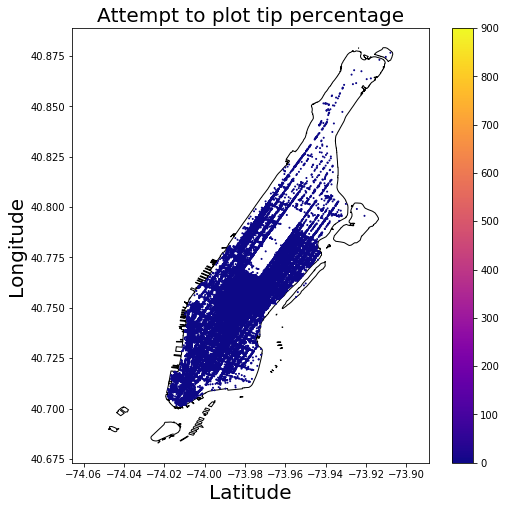

In [60]:
ax = nycshp.loc[[0], 'geometry'].plot(edgecolor = "black", color = 'white', figsize=(8, 8))
# nycshp.plot(edgecolor = "r", ax = ax, alpha=0.5)
#set the axis differently
ax.axes.set_aspect('equal','datalim')
# fig,ax = cp.choroplethNYC(nycshp.loc[[0], 'geometry'], column=None, color="white", edgecolor="black", lw=0.5)
uber_man.plot(column='tip_percent', cmap='plasma', ax = ax, markersize=1, legend=True)
plt.xlabel('Latitude', fontsize=20)
plt.ylabel('Longitude', fontsize=20)
plt.title('Attempt to plot tip percentage', fontsize=20)

## Figure 2: Attempt to plot tip percentage but found an issue. Because tip percentage should be normalized to the range between 0.0-1.0, but there was a maximum value of 900. So I need to further inspect the data to get rid of noisy values.  

In [61]:
uber_man = uber_man.reset_index()

In [62]:
uber_man.tip_percent.max()

900.0

In [63]:
uber_man.tip_percent.idxmax(axis=0, skipna=True)

59987

##### Looks like the trip that has 900% tip is at index 42625

In [64]:
uber_man[59987:59988]

,index,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tip_amount,total_amount,pickup_lonlat,geometry,tip_percent
59987,64306,1,2015-01-15 13:46:03 +00:00,2015-01-15 13:46:18 +00:00,1,0.0,-73.982903,40.735008,-73.98291,40.735149,0.01,9.0,9.31,"(-73.98290253, 40.73500824)",POINT (-73.98290253 40.73500824),900.0


##### After looking at this specific trip, I realize the fare_amount was 0.01, and the tip_amount was 9.0. I think this is because there was a mistake when this trip happened and the driver was not able to charge the passenger correctly, so the passenger pay the driver with tip instead. I decided to drop this row.

In [65]:
# drop this row
uber_man.drop([uber_man.tip_percent.idxmax(axis=0, skipna=True)], inplace=True)

##### Because there are a very small amount of trips that has tip_pervent larger than 1, which will have a big impact on the scale of color when plotting. I decided to drop all the trips with tip_percent more then 1 to get a visualization that is more legible.

In [66]:
uber_man['tip_percent'].nlargest(50)

61746    6.000000
33452    5.600000
71908    5.466667
35129    5.200000
91197    4.040000
64848    4.000000
83642    3.600000
71629    3.400000
57671    3.089412
7526     2.857143
85192    2.857143
87877    2.400000
78250    2.363636
4164     2.250000
46562    2.142857
2829     2.000000
14226    2.000000
39505    2.000000
76666    2.000000
77438    2.000000
16644    1.904762
83114    1.900000
47301    1.750000
63592    1.666667
103      1.600000
9630     1.600000
27649    1.600000
27866    1.600000
36082    1.538462
82258    1.538462
33984    1.454545
76084    1.444000
16441    1.428571
33433    1.428571
22093    1.400000
77726    1.400000
58812    1.333333
67313    1.333333
57394    1.250000
74330    1.250000
23181    1.244444
41031    1.222222
34574    1.200000
75919    1.200000
84038    1.200000
60899    1.166667
20554    1.153846
70704    1.153846
27202    1.150000
90152    1.145263
Name: tip_percent, dtype: float64

In [67]:
uber_man.drop([61746,33452,71908,35129,91197,64848,83642,71629,57671,7526,85192,87877,78250,4164,46562,2829,14226,39505,76666,77438,16644,83114,47301,63592,103,9630,27649,27866,36082,82258,33984,76084,16441,33433,22093,77726,58812,67313,57394,74330,23181,41031,34574,75919,84038,60899,20554,70704,27202,90152,89985,7257,55150,58314,55757,38355,89526,21159,78427,90385], inplace=True)

In [68]:
uber_man['tip_percent'].max()

1.0

Text(0.5,1,' Uber trips start location refelcting tip percentage of each trip in Manhanttan on Jan 15th, 2015.')

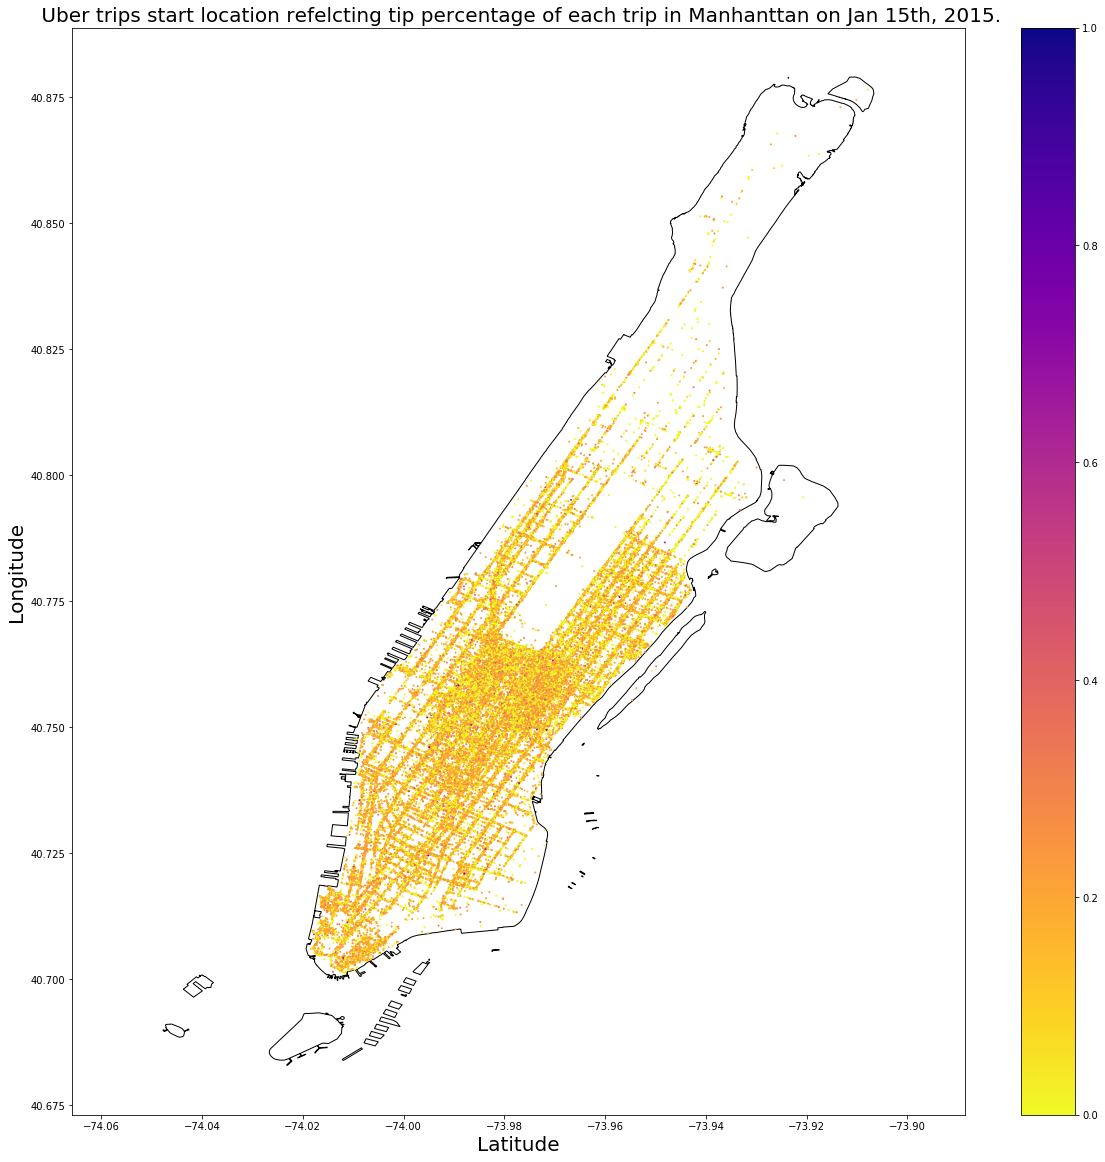

In [69]:
ax = nycshp.loc[[0], 'geometry'].plot(edgecolor = "black", color = 'white', figsize=(20, 20))
ax.axes.set_aspect('equal','datalim')
uber_man.plot(column='tip_percent', cmap=cmap_reversed, ax = ax, markersize=1, legend=True)
plt.xlabel('Latitude', fontsize=20)
plt.ylabel('Longitude', fontsize=20)
plt.title(' Uber trips start location refelcting tip percentage of each trip in Manhanttan on Jan 15th, 2015.', fontsize=20)

## Figure 4: Map of color-coded Uber trips' start location refelcting tip percentage of each trip in Manhanttan on Jan 15th, 2015. (less tip percentage is more yellow, more tip percentage is more pueple). This map shows that most of the tip percentage is between 0-4%, some are 4-6%, very seldomly above 6%. 